In [1]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data'
MODEL_PATH = '/home/dmig/work/upsell/model'

In [3]:
RESULT_PATH = '/home/dmig/work/upsell/result/feature_order'

In [4]:
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart04 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201904.pkl'))
df_mart05 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201905.pkl'))

df_input06 = pd.read_pickle(os.path.join(DATA_PATH, 'df_input_201906.pkl'))

In [5]:
total_feature = list(df_mart01.columns)
feature_cols = [c for c in total_feature if c not in ['svc_mgmt_num', 'label']]

In [20]:
def xgb_model(x_trn, y_trn, x_val, y_val, feature_cols=feature_cols):
    xgb_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc', #logloss, error, auc
            'n_estimators': 500,
            'eta': 0.1,
            'max_depth': 6,
            'min_child_weight': 1,
            'scale_pos_weight': 4, # neg/pos
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 23,
            'nthread': 30,
            'verbosity': 1
        }
        
    clf = xgb.XGBClassifier(**xgb_params)
    t1 = time.time()
    clf.fit(x_trn, y_trn.label.values, 
             eval_set=[(x_trn, y_trn.label.values), 
                       (x_val, y_val.label.values)],
            early_stopping_rounds=100, verbose=200)
    print('elapsed time: ', time.time()-t1)

    return clf

In [26]:
trn_data = make_train_data(df_mart04)
x_trn = trn_data['trn']['x']
y_trn = trn_data['trn']['y']
x_val = trn_data['val']['x']
y_val = trn_data['val']['y']

make_train_data +++
label/sample:  0.2
sample/total:  0.13686330463107405
make_data_for_modeling---


In [27]:
test_data = make_test_data(df_mart01)
x_tst = test_data['x']
y_tst = test_data['y']

In [18]:
reversed_feature_cols = [f for f in reversed(feature_cols)]

In [21]:
clf = xgb_model(x_trn[reversed_feature_cols], y_trn, 
                x_val[reversed_feature_cols], y_val, 
                feature_cols=reversed_feature_cols)

[0]	validation_0-auc:0.745358	validation_1-auc:0.743648
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.828186	validation_1-auc:0.822852
[400]	validation_0-auc:0.839389	validation_1-auc:0.829785
[499]	validation_0-auc:0.843869	validation_1-auc:0.832308
elapsed time:  395.1415636539459


        acc    recall  precision  f1_score       auc
0  0.734103  0.773133     0.0518  0.097095  0.836111
         pred: 1   pred: 0
true: 1   259860     76253
true: 0  4756749  13083353


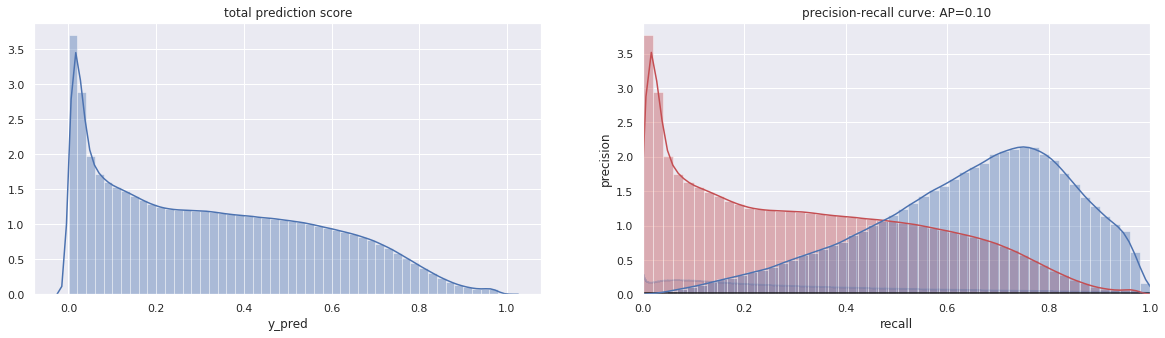

In [29]:
eval_result = evaluate(x_tst[reversed_feature_cols],
                       y_tst.label.values, clf, clf_name='xgb')

In [25]:
pd.DataFrame({'feature': reversed_feature_cols,
             'importance': clf.feature_importances_}).sort_values('importance', ascending=False).head(20)

feature  importance
25            data_usage_ratio    0.063887
17            overage_5k_3m_or    0.058847
22   bf_m3_data_over_usage_cnt    0.056424
51      data_usage_in_gb_bf_m1    0.040795
31             real_arpu_bf_m2    0.038289
45       copn_data_u1_yn_bf_m0    0.037227
72           last_equip_period    0.036282
0                      channel    0.032958
9           mth_cnsl_cnt_bf_m0    0.031552
48                 overage_bf0    0.030735
36                  sec_dev_yn    0.028269
44       copn_data_u1_yn_bf_m1    0.026806
66                   family_yn    0.024732
71                 bas_fee_amt    0.022683
29               real_avg_arpu    0.021903
28           bf_m3_fee_chg_cnt    0.021614
70             bas_ofr_data_gb    0.019954
55  ref_data_usage_in_gb_bf_m0    0.019313
32             real_arpu_bf_m1    0.019054
77                         age    0.018258

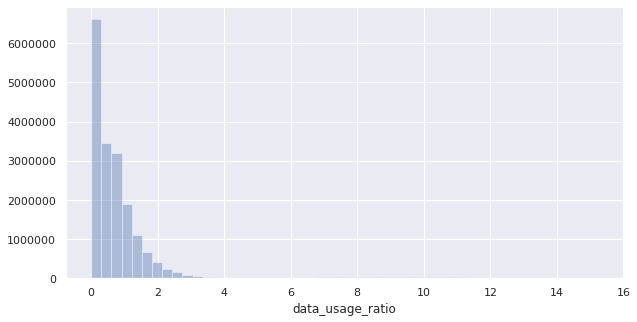

In [45]:
sns.distplot(np.log1p(df_mart04['data_usage_ratio']), norm_hist=False, kde=None)

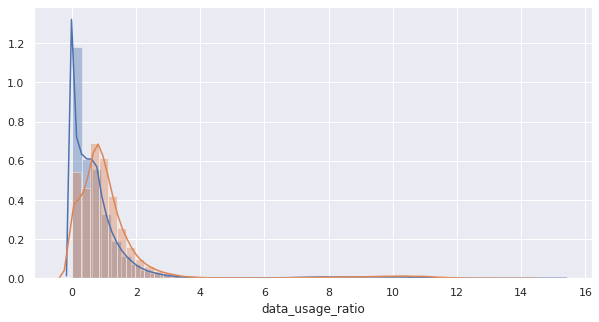

In [48]:
sns.distplot(np.log1p(df_mart04[df_mart04['label']==0]['data_usage_ratio']))
sns.distplot(np.log1p(df_mart04[df_mart04['label']==1]['data_usage_ratio']))

In [38]:
df_mart04.shape

(18626176, 81)

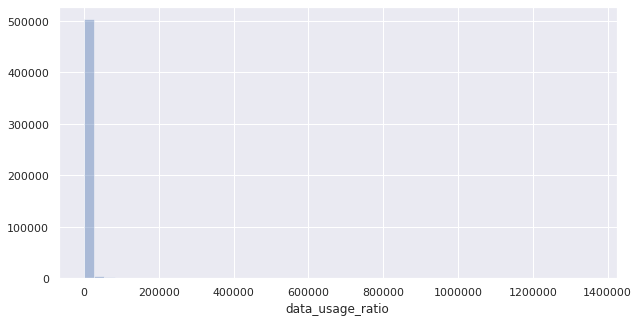

In [44]:
sns.distplot(df_mart04[df_mart04['label']==1]['data_usage_ratio'], norm_hist=False, kde=None)

In [43]:
df_mart04[df_mart04['label']==1].shape

(509848, 81)

In [42]:
df_mart04[df_mart04['data_usage_ratio']>100000].shape[0]

19656

In [ ]:
sns.set(rc={'fiture.figsize': (10,5)})
df_mart04[['data_usage_ratio', 'label']]
sns.distplot(df_mart04['data_usage_ratio'], norm_hist=False, kde=none)

In [19]:
x_trn[reversed_feature_cols]

channel  simpl_ref_cnsl_cnt_bf_m2  simpl_ref_cnsl_cnt_bf_m1  \
7375003         3                         0                         0   
15219048        3                         0                         0   
2402391         3                         0                         0   
14514748        2                         0                         4   
18234402        1                         0                         0   
6956141         3                         0                         0   
10616204        3                         0                         0   
281688          3                         0                         0   
16612464        3                         0                         1   
8834898         3                         0                         3   
1261488         1                         0                         0   
18259526        1                         0                         0   
7210726         3                         0                         0   
8137024         2                         0                         0   
13633276        3                         0                         0   
4475439         1                         0                         0   
12984428        3                         0                         0   
17514775        1                         0                         0   
12343979        2                         0                         1   
9485729         3                         0                         0   
911266          2                         0                         0   
2988400         3                         0                         0   
3005816         3                         0                         0   
15688213        1                         0                         2   
8813847         3                         0                         0   
5414186         3                         0                         0   
5714128         3                         0                         3   
15390875        2                         0                         0   
5279230         3                         0                         0   
10928905        2                         0                         0   
...           ...                       ...                       ...   
9829944         1                         0                         0   
6635775         2                         0                         0   
10965042        3                         2                         0   
9115019         1                         0                         0   
8330038         2                         0                         0   
5120338         3                         0                         2   
15529919        2                         0                         0   
10017021        3                         0                         0   
2212577         3                         0                         0   
10607215        2                         0                         0   
6841364         1                         0                         0   
3309347         3                         0                         0   
13417620        3                         0                         2   
3346413         3                         0                         0   
13866113        3                         1                         1   
7631027         3                         0                         0   
18498414        1                         0                         0   
10100799        3                         0                         0   
1116833         3                         0                         0   
9110413         3                         0                         0   
4323171         3                         0                         0   
12044131        3                         0                         0   
9883319         1                         1                         

In [ ]:
def show_plots(df, cols):
    print('col: ', col)
    sns.set(rc={'fiture.figsize': (10,5)})
    
    print('label distribution')
    sns.distplot()